# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [4]:
def entropy(a: np.ndarray) -> float:
    p = a / np.sum(a)
    return -np.sum(p * np.log(p))

print(f"{entropy(np.array([8, 2])):.2f}")

0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [5]:
c = np.array([1, 2, 3, 3])
np.unique(c, return_counts=True)

(array([1, 2, 3]), array([1, 1, 2], dtype=int64))

In [6]:
from typing import Callable

def gini(a: np.ndarray) -> float:
    _, c = np.unique(a, return_counts=True)
    p = c / c.sum()
    return np.sum(p * (1 - p))

def impurity_criterion(a: np.ndarray[float], in_threshold: np.ndarray[bool], h_func: Callable[[np.ndarray], float]) -> float:
    al = a[in_threshold]
    ar = a[~in_threshold]
    return h_func(a) - al.size / a.size * h_func(al) - ar.size / a.size * h_func(ar)

arr = np.array([1]*8 + [2]*2)
in_threshold = arr == 1
print(f"{impurity_criterion(arr, in_threshold, gini):.2f}")

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

> Ну вообще-то предсказания модели зависят от функции потерь, которую мы выберем. Но допустим что мы как нормальные люди взяли MSE и поэтому берём среднее арифметическое в листе

In [7]:
def leaf_predict(arr: np.ndarray):
    return np.full_like(arr, arr.mean())

arr = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
print(leaf_predict(arr))

[40 40 40 40 40 40 40 40 40 40]


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [8]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [9]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)

    if task == "classification":
        h_func = gini
    elif task == "regression":
        h_func = np.var
    else:
        raise ValueError('task должно быть либо "classification", либо "regression"')
    
    thresholds = np.unique(np.sort(feature_vector))
    if feature_type == "real":
        thresholds = (thresholds[:-1] + thresholds[1:]) / 2
        in_threshold_func = np.less
    elif feature_type == "categorical":
        in_threshold_func = np.equal
    else:
        raise ValueError('feature_type должно быть либо "real", либо "categorical"')
    if len(thresholds) == 0:
        return thresholds, thresholds.copy(), None, None
    
    vectorized_impurity_criterion = np.vectorize(
        lambda th: impurity_criterion(target_vector, in_threshold_func(feature_vector, th), h_func)
    )
    ginis = vectorized_impurity_criterion(thresholds)
    best_idx = np.argmax(ginis)
    return thresholds, ginis, thresholds[best_idx], ginis[best_idx]

Эту функцию можно протестировать на датасете `California`.

In [10]:
from sklearn.datasets import fetch_california_housing

In [11]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [12]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

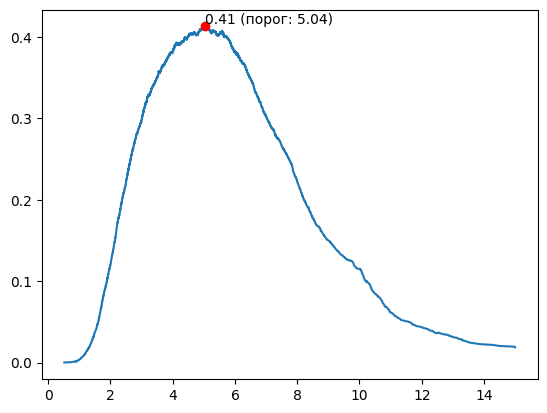

In [13]:
arr = X["MedInc"]
thresholds, ginis, threshold_best, gini_best = find_best_split(arr, y, "regression", "real")
plt.plot(thresholds, ginis, zorder=0)
plt.scatter(threshold_best, gini_best, c="red", zorder=1)
plt.text(
    threshold_best, gini_best, 
    f"{gini_best:.2f} (порог: {threshold_best:.2f})", 
    va="bottom", ha="left" if threshold_best * 2 < thresholds[0] + thresholds[-1] else "right"
)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [14]:
from matplotlib.axes import Axes

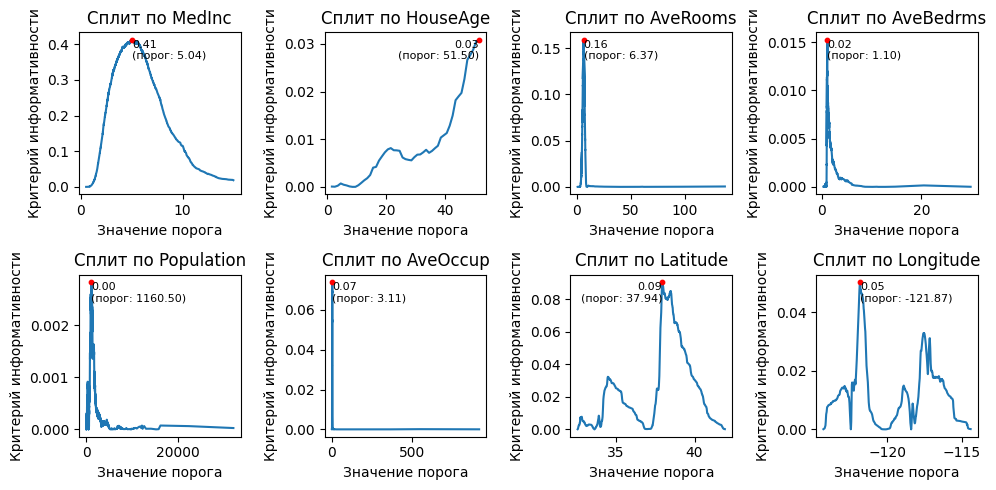

Лучшее деление: по признаку MedInc и порогу 5.035. Критерий информативности = 0.413


In [15]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
axs: np.ndarray
best_feature = None
best_gini = 0
best_threshold = None
for feat, ax in zip(X.columns, axs.flatten()):
    ax: Axes
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[feat], y, "regression", "real")
    ax.plot(thresholds, ginis, zorder=0)
    ax.scatter(threshold_best, gini_best, c="red", s=10, zorder=1)
    ax.text(
        threshold_best, gini_best, 
        f"{gini_best:.2f}\n(порог: {threshold_best:.2f})", fontsize=8,
        va="top", ha="left" if threshold_best * 2 < thresholds[0] + thresholds[-1] else "right"
    )
    ax.set_title(f"Сплит по {feat}")
    ax.set_xlabel("Значение порога")
    ax.set_ylabel("Критерий информативности")
    if gini_best > best_gini:
        best_gini = gini_best
        best_threshold = threshold_best
        best_feature = feat
plt.tight_layout()
plt.show()
print(f"Лучшее деление: по признаку {best_feature} и порогу {best_threshold:.3f}. Критерий информативности = {best_gini:.3f}")

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [38]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        if self.task != "classification":
            raise NotImplementedError(f"Дерево решений для задачи {self.task} не реализовано")
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError(f"Неизвестный тип признака: {self._feature_types[feature_best]}")
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        
        feat = node["feature_split"]
        if self._feature_types[feat] == "real":
            child = "left_child" if x[feat] < node["threshold"] else "right_child"
        elif self._feature_types[feat] == "categorical":
            child = "left_child" if x[feat] == node["category_split"] else "right_child"
        else:
            raise ValueError(f"Неизвестный тип признака: {self._feature_types[feat]}")
        return self._predict_node(x, node[child])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [17]:
df = pd.read_csv('students.csv', index_col=0)
X = df.iloc[:, :5]
y = df.iloc[:, 5]
display(X.head(), y.head())

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


0    0
1    1
2    0
3    1
4    0
Name: UNS, dtype: int64

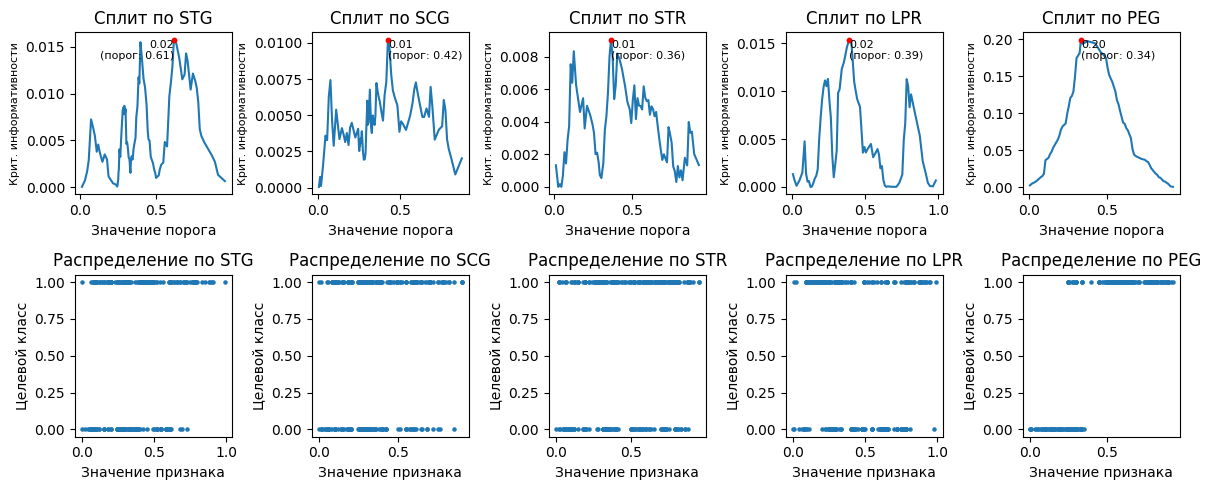

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
# best_feature = None
# best_gini = 0
# best_threshold = None
for feat, ax1, ax2 in zip(X.columns, *axs):
    ax1: Axes
    ax2: Axes
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[feat], y, "regression", "real")
    ax1.plot(thresholds, ginis, zorder=0)
    ax1.scatter(threshold_best, gini_best, c="red", s=10, zorder=1)
    ax1.text(
        threshold_best, gini_best, 
        f"{gini_best:.2f}\n(порог: {threshold_best:.2f})", fontsize=8,
        va="top", ha="left" if threshold_best * 2 < thresholds[0] + thresholds[-1] else "right"
    )
    ax1.set_title(f"Сплит по {feat}", fontsize=12)
    ax1.set_xlabel("Значение порога")
    ax1.set_ylabel("Крит. информативности", fontsize=8)
    ax2.scatter(X[feat], y, s=5)
    ax2.set_title(f"Распределение по {feat}", fontsize=12)
    ax2.set_xlabel("Значение признака")
    ax2.set_ylabel("Целевой класс")
    # if gini_best > best_gini:
    #     best_gini = gini_best
    #     best_threshold = threshold_best
    #     best_feature = feat
plt.tight_layout()
plt.show()
# print(f"Лучшее деление: по признаку {best_feature} и порогу {best_threshold:.3f}. Критерий информативности = {best_gini:.3f}")

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

> `PEG`, очевидно, должен разделять классы лучше всего. Критерий Джини тоже так считает: критерий информативности в вершине графика для `PEG` равен 0.2, тогда как в вершинах графиков остальных признаков он едва ли достигает 0.02. График критерия информативности для признака, хорошо разделяющего классы, выглядит как плавная горка — и это логчично, в нём есть конкретное место для разреза который сводит энтропию почти к нулю. Остальные графики похожи на сейсмограмму, но на самом деле это просто потому, что это почти случайные числа, едва отличающиеся от нуля (то есть на самом деле это кривоватая линия идущая по дну)

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [31]:
from sklearn.preprocessing import LabelEncoder

mushrooms = pd.read_csv("agaricus-lepiota.data", header=None)
encode = LabelEncoder()
y = encode.fit_transform(mushrooms.iloc[:, 0])
X = mushrooms.iloc[:, 1:].apply(encode.fit_transform).to_numpy()
display(X, y)

array([[5, 2, 4, ..., 2, 3, 5],
       [5, 2, 9, ..., 3, 2, 1],
       [0, 2, 8, ..., 3, 2, 3],
       ...,
       [2, 2, 4, ..., 0, 1, 2],
       [3, 3, 4, ..., 7, 4, 2],
       [5, 2, 4, ..., 4, 1, 2]])

array([1, 0, 0, ..., 0, 1, 0])

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=239)
tree = DecisionTree(["categorical"] * X.shape[1])
tree.fit(X_train, y_train)

In [41]:
from sklearn.metrics import accuracy_score

print(f"Accuracy на обучающей выборке: {accuracy_score(y_train, tree.predict(X_train)):.5f}")
print(f"Accuracy на тестовой выборке: {accuracy_score(y_test, tree.predict(X_test)):.5f}")

Accuracy на обучающей выборке: 1.00000
Accuracy на тестовой выборке: 0.99951


> На обучающей выборке accuracy 1, потому что ну это решающее дерево, у него почти всегда будет так. На тестовой выборке очень близко к 1, это уже удивительно — видимо, свойства грибов реально неплохо предсказываются по этим параметрам

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [47]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [43]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

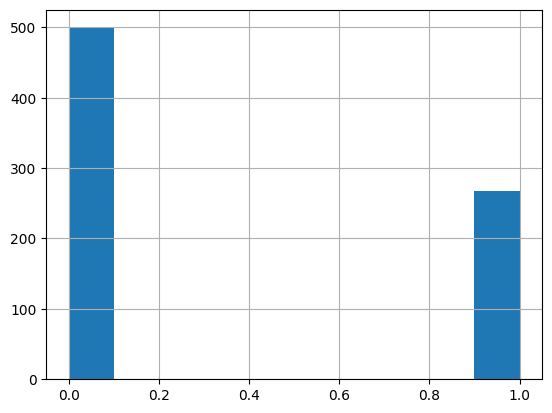

In [44]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [46]:
X = data[data.columns[data.columns != "Outcome"]]
y = data["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=239)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=157)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [77]:
from tqdm.contrib.itertools import product

hypervalues = list(range(1, 11))

best_max_depth = None
best_min_samples_leaf = None
best_f1 = 0

print("Подбор гиперпараметров...")
for max_depth, min_samples_leaf in product(hypervalues, hypervalues):
    tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=239)
    tree.fit(X_train_train, y_train_train)
    f1 = f1_score(y_train_val, tree.predict(X_train_val))
    if f1 > best_f1:
        best_max_depth = max_depth
        best_min_samples_leaf = min_samples_leaf
        best_f1 = f1
print(f"max_depth={best_max_depth}, min_samples_leaf={best_min_samples_leaf} (f1={best_f1:.3f})")

Подбор гиперпараметров...


100%|██████████| 100/100 [00:01<00:00, 79.97it/s]

max_depth=5, min_samples_leaf=8 (f1=0.762)


In [78]:
from typing import Callable

tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=239)
tree.fit(X_train, y_train)

def print_metrics(y_test, y_pred):
    metrics: dict[str, Callable] = {
        "Accuracy": accuracy_score,
        "Точность": precision_score,
        "Полнота": recall_score,
        "ROC-AUC": roc_auc_score
    }
    for name, score in metrics.items():
        print(f"{name}: {score(y_test, y_pred):.3f}")

print_metrics(y_test, tree.predict(X_test))

Accuracy: 0.680
Точность: 0.463
Полнота: 0.449
ROC-AUC: 0.614


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [79]:
bagging = BaggingClassifier(n_estimators=50, random_state=239)
bagging.fit(X_train, y_train)
print_metrics(y_test, bagging.predict(X_test))

Accuracy: 0.706
Точность: 0.506
Полнота: 0.565
ROC-AUC: 0.665


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [80]:
from sklearn.model_selection import cross_val_score

best_max_depth = None
best_min_samples_split = None
best_f1 = 0
hypervalues = [2, 3, 5, 7, 10, 15]

print("Подбор гиперпараметров...")
for max_depth, min_samples_split in product(hypervalues, hypervalues):
    random_forest = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=239)
    f1_array = cross_val_score(random_forest, X_train, y_train, cv=3, scoring="f1")
    f1 = f1_array.mean()
    if f1 > best_f1:
        best_f1 = f1
        best_max_depth = max_depth
        best_min_samples_split = min_samples_split
print(f"max_depth={best_max_depth}, min_samples_split={best_min_samples_split} (f1={best_f1:.3f})")

Подбор гиперпараметров...


100%|██████████| 36/36 [00:15<00:00,  2.40it/s]

max_depth=10, min_samples_split=5 (f1=0.695)


In [81]:
random_forest = RandomForestClassifier(50, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=239)
random_forest.fit(X_train, y_train)
print_metrics(y_test, random_forest.predict(X_test))

Accuracy: 0.745
Точность: 0.581
Полнота: 0.522
ROC-AUC: 0.681


> По всем четырём оценкам получается что: Бэггинг > Одно дерево и Случайный лес > Одно дерево. Не очень удивительно. Бэггинг выиграл случайный лес по полноте, но проиграл по другим двум критериям.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [85]:
from tqdm import tqdm

ns = list(range(1, 101))
auc_rocs = []

print("Расчёт AUC-ROC...")
for n in tqdm(ns):
    forest = RandomForestClassifier(n, random_state=239) #, max_depth=best_max_depth, min_samples_split=best_min_samples_split)
    forest.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, forest.predict(X_test)))

Расчёт AUC-ROC...


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


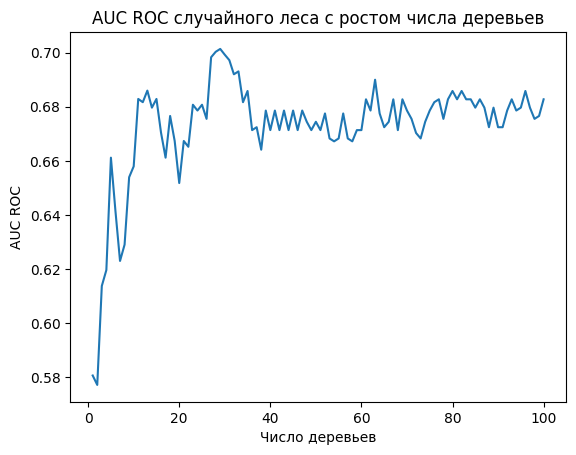

In [90]:
plt.plot(ns, auc_rocs)
plt.title("AUC ROC случайного леса с ростом числа деревьев")
plt.xlabel("Число деревьев")
plt.ylabel("AUC ROC")
plt.show()

> Увеличение числа деревьев полезно не до бесконечности. Оптимальное число — в районе нескольких десятков, после полусотни деревьев никаких значимых улучшений можно не ожидать

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

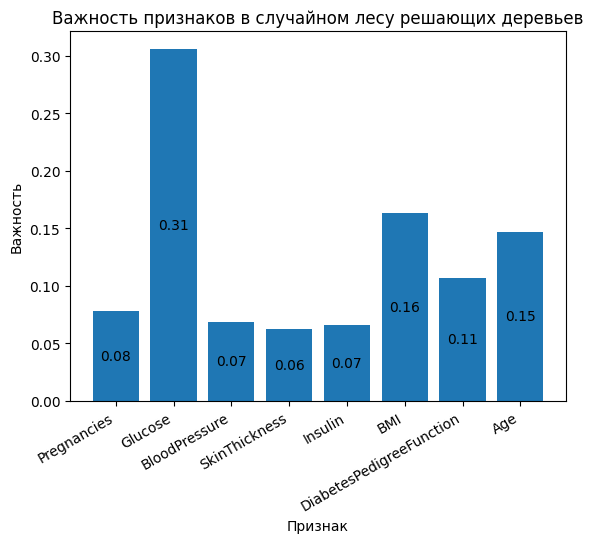

In [102]:
x, y = random_forest.feature_names_in_, random_forest.feature_importances_
plt.bar(x, y)
for i in range(len(x)):
    plt.text(i, y[i] / 2, f"{y[i]:.2f}", va="center", ha="center")
ticks, _ = plt.xticks(rotation=30, ha="right")
plt.title("Важность признаков в случайном лесу решающих деревьев")
plt.xlabel("Признак")
plt.ylabel("Важность")
plt.show()

> Самый важный признак: уровень глюкозы (`Glucose`, *importance* = 0.31). Следом идут `BMI` (0.16) и возраст `Age` (0.15)